### Defined by MMG model, KVLCC2 : full size
### u, v, r, nps ---calculate--->  Engine Power

In [24]:
import pandas as pd
import math
import numpy as np

# 读取 CSV 数据
file_path = 'MARIN_FREE_KVLCC2_zz_-20_m.csv'  # 替换为你的实际文件路径
data = pd.read_csv(file_path)

# 提取原始数据列
u = data.iloc[:, 5]    # 纵向速度 (m/s)
v_m = data.iloc[:, 6]  # 横向速度 (m/s)
r = data.iloc[:, 8]    # 偏航速度 (deg/s)
Np = data.iloc[:, 10]  # 螺旋桨转速 (rpm)

# 全尺寸参数
Lpp = 320.0    
x_P = -160.0  
rho = 1000    
Dp = 9.86      

C1 = 2.0
C_2_plus = 1.6
C_2_minus = 1.1

w_P0 = 0.35 

eta_gear = 0.95
eta_shaft = 0.97

# 计算主机功率的函数
def calculate_P_engine(u, v_m, r, Np):
    Np_rps = Np / 60  # rpm -> rps
    U = math.sqrt(u**2 + v_m**2)  

    if U == 0.0:
        beta = 0.0
        r_dash = 0.0
    else:
        beta = math.atan(-v_m / u)  
        r_dash = r * (math.pi / 180) * Lpp / U  

    beta_P = beta - (x_P / Lpp) * r_dash
    C_2 = C_2_plus if beta_P >= 0 else C_2_minus
    tmp = (1 - math.exp(-C1 * abs(beta_P))) * (C_2 - 1)
    w_P = 1 - (1 - w_P0) * (1 + tmp)  

    if Np_rps == 0.0:
        Jp = 0.0
    else:
        Jp = (1 - w_P) * u / (Np_rps * Dp)  

    K_T = -0.1476*Jp**2 - 0.2219*Jp + 0.3243
    Fp = rho * Np_rps**2 * Dp**4 * K_T     

    K_Q = -0.0119*Jp**3 - 0.0074*Jp**2 - 0.0186*Jp + 0.0370
    Tp = rho * Np_rps**2 * Dp**5 * K_Q   

    P_propeller = 2 * math.pi * Np_rps * Tp  
    P_engine = P_propeller / (eta_gear * eta_shaft)  
    
    return P_engine / 1000, Tp, K_Q, Fp, K_T, Jp, w_P

# 计算所有样本的中间变量
results = [calculate_P_engine(u_i, v_m_i, r_i, Np_i) for u_i, v_m_i, r_i, Np_i in zip(u, v_m, r, Np)]

# 将结果添加到 DataFrame
data['P_engine'] = [result[0] for result in results]
data['Tp'] = [result[1] for result in results]
data['K_Q'] = [result[2] for result in results]
data['Fp'] = [result[3] for result in results]
data['K_T'] = [result[4] for result in results]
data['Jp'] = [result[5] for result in results]
data['w_P'] = [result[6] for result in results]

# 输出最大最小值
print(f"\nEngine power 'P_engine': max = {data['P_engine'].max()}, min = {data['P_engine'].min()}")
print(f"\n'w_P': max = {data['w_P'].max()}, min = {data['w_P'].min()}")
print(f"\n'Jp': max = {data['Jp'].max()}, min = {data['Jp'].min()}")
print(f"\nThrust 'Fp': max = {data['Fp'].max()}, min = {data['Fp'].min()}")
print(f"\nThrust coefficient 'K_T': max = {data['K_T'].max()}, min = {data['K_T'].min()}")
print(f"\nTorque 'Tp': max = {data['Tp'].max()}, min = {data['Tp'].min()}")
print(f"\nTorque coefficient 'K_Q': max = {data['K_Q'].max()}, min = {data['K_Q'].min()}")

# 保存到 CSV 文件
output_file = 'full_calculated_results.csv'
data.to_csv(output_file, index=False)
print(f"\n计算结果已保存到 {output_file}")



Engine power 'P_engine': max = 73645.68913295324, min = 63706.33897258024

'w_P': max = 0.3499894157292355, min = 0.06614642725874442

'Jp': max = 0.3748411833800223, min = 0.2269405511306052

Thrust 'Fp': max = 5904491.363041672, min = 4833678.345277404

Thrust coefficient 'K_T': max = 0.2663401944749932, min = 0.22038406868493127

Torque 'Tp': max = 7051776.521705862, min = 6133426.62249633

Torque coefficient 'K_Q': max = 0.032258704892167714, min = 0.028361468143665344

计算结果已保存到 full_calculated_results.csv


## Calculate Kq and Kt by polyfit func, data are from SIMMAN2020 

拟合的Kq多项式：
Kq = -0.0119*Jp^3 + -0.0074*Jp^2 + -0.0186*Jp + 0.0370
拟合的Kt多项式：
Kt = -0.1476*Jp^2 + -0.2219*Jp + 0.3243


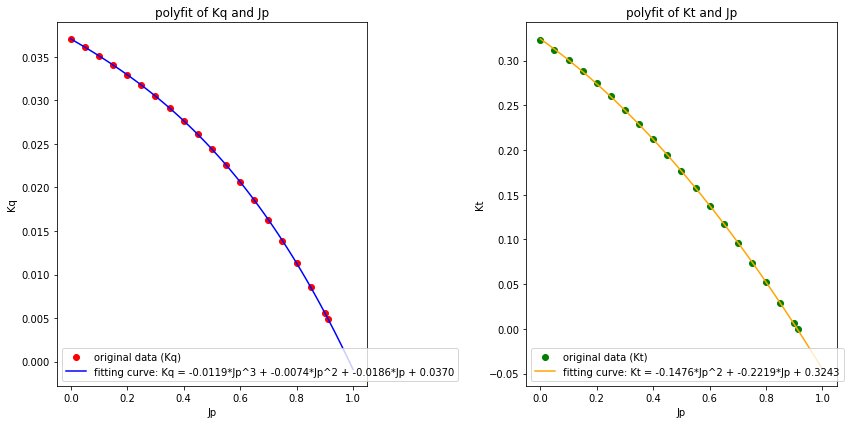

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# 数据
Jp = np.array([0.000, 0.050, 0.100, 0.150, 0.200, 0.250, 0.300, 0.350, 0.400, 0.450, 
               0.500, 0.550, 0.600, 0.650, 0.700, 0.750, 0.800, 0.850, 0.900, 0.912])
Kq = np.array([0.3704, 0.3609, 0.3510, 0.3404, 0.3293, 0.3174, 0.3047, 0.2911, 0.2765, 0.2608, 
               0.2440, 0.2259, 0.2064, 0.1855, 0.1630, 0.1390, 0.1132, 0.0857, 0.0562, 0.0488])
Kt = np.array([0.323, 0.312, 0.301, 0.288, 0.275, 0.261, 0.245, 0.229, 0.212, 0.195, 
               0.176, 0.157, 0.137, 0.117, 0.096, 0.074, 0.052, 0.029, 0.006, 0.000])

# 调整 Kq 值为原来的10倍
Kq = Kq / 10

# 使用 numpy.polyfit 拟合 Kq 的三次多项式
coefficients_Kq = np.polyfit(Jp, Kq, 3)
C1, C2, C3, C0 = coefficients_Kq
polynomial_Kq = f"Kq = {C1:.4f}*Jp^3 + {C2:.4f}*Jp^2 + {C3:.4f}*Jp + {C0:.4f}"

# 使用 numpy.polyfit 拟合 Kt 的二次多项式
coefficients_Kt = np.polyfit(Jp, Kt, 2)
a2, a1, a0 = coefficients_Kt
polynomial_Kt = f"Kt = {a2:.4f}*Jp^2 + {a1:.4f}*Jp + {a0:.4f}"

# 打印出多项式系数
print("拟合的Kq多项式：")
print(polynomial_Kq)
print("拟合的Kt多项式：")
print(polynomial_Kt)

# 创建拟合曲线
Jp_fit = np.linspace(0, 1, 100)
Kq_fit = C1 * Jp_fit**3 + C2 * Jp_fit**2 + C3 * Jp_fit + C0
Kt_fit = a2 * Jp_fit**2 + a1 * Jp_fit + a0

# 绘制原始数据点和拟合曲线
plt.figure(figsize=(12, 6))

# 绘制 Kq 的拟合曲线
plt.subplot(1, 2, 1)
plt.scatter(Jp, Kq, label='original data (Kq)', color='red')
plt.plot(Jp_fit, Kq_fit, label=f'fitting curve: {polynomial_Kq}', color='blue')
plt.xlabel('Jp')
plt.ylabel('Kq')
plt.title('polyfit of Kq and Jp')
plt.legend()

# 绘制 Kt 的拟合曲线
plt.subplot(1, 2, 2)
plt.scatter(Jp, Kt, label='original data (Kt)', color='green')
plt.plot(Jp_fit, Kt_fit, label=f'fitting curve: {polynomial_Kt}', color='orange')
plt.xlabel('Jp')
plt.ylabel('Kt')
plt.title('polyfit of Kt and Jp')
plt.legend()

plt.tight_layout()
plt.show()
